# ¿Que más se podría hacer?

- Test con data augmentation y la LSTM
- Usar los tokenizadores usados en los transformers para ver como funcionan
- TSNE de embeddings y analizar si hay interpretación
- Probar con otras encimas o proteinas
- Usar los embeddings entrenados para analizar resultados de proteinas o encimas con menos data
- Entrenar una red neuronal con los features (fingerprints por ejemplo) y comparar los resultados con los embeddings

# Realizo la primera Test con data augmentation y la LSTM

In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Modelo LSTM con generador, embedings de smiles y data-augmentation

In [44]:
#!pip install rdkit-pypi

In [45]:
import pandas as pd
import numpy as np
from datagen import smiles_dict, smiles_to_seq

### smiles_dict

In [46]:
len(smiles_dict)

42

smiles_dict nos da un tokenizador para simplificar el problema. Puede ver como se construyó en la notebook **deep_chem**.
Si al momento de correr el modelo con este diccionario encuentra problemas de key_error, puede agregar los faltantes al diccionario

Mirar dentro de **datagen.py** como se usa este diccionario con la función **smiles_to_seq** para tokenizar. El código es muy sencillo

In [47]:
print(smiles_dict)

{'#': 1, '(': 2, ')': 3, '+': 4, '-': 5, '/': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '=': 15, 'C': 16, 'F': 17, 'H': 18, 'I': 19, 'N': 20, 'O': 21, 'P': 22, 'S': 23, '[': 24, '\\': 25, ']': 26, '_': 27, 'c': 28, 'Cl': 29, 'Br': 30, 'n': 31, 'o': 32, 's': 33, '@': 34, '.': 35, 'a': 36, 'B': 37, 'e': 38, 'i': 39, '9': 40, '10': 41, '11': 42}


# Carga de los datos

In [48]:
df = pd.read_csv('data/acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

In [49]:
max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()
max_sequence_len = len(df['canonical_smiles'].iloc[max_len_idx]) + 20

In [50]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910


In [51]:
X = df['canonical_smiles'].values
y = df['pIC50'].values

# Data augmentation:

https://arxiv.org/pdf/1703.07076.pdf

https://github.com/EBjerrum/molvecgen

https://github.com/Ebjerrum/SMILES-enumeration

En la publicación de arriba se describe una técnica de aumentación de datos para los smiles. Leerla si es de su interes (Opcional)

En el módulo **dataug.py**, tomando como referencia los repositorios arriba citados se implementó la aumentación de datos

In [52]:
seq = 'CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'

from dataaug import SmilesEnumerator
sme = SmilesEnumerator()
for i in range(10):
    print(sme.randomize_smiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))

c1cccc(COc2cccc(-n3nc(OCC)oc3=O)c2)c1
c1c(-n2nc(OCC)oc2=O)cc(OCc2ccccc2)cc1
c1c(-n2c(=O)oc(OCC)n2)cccc1OCc1ccccc1
c1c(-n2nc(OCC)oc2=O)cccc1OCc1ccccc1
c1(OCc2ccccc2)cc(-n2nc(OCC)oc2=O)ccc1
n1(-c2cccc(OCc3ccccc3)c2)nc(OCC)oc1=O
c1(OCc2ccccc2)cc(-n2nc(OCC)oc2=O)ccc1
n1(-c2cc(OCc3ccccc3)ccc2)c(=O)oc(OCC)n1
c1ccc(-n2c(=O)oc(OCC)n2)cc1OCc1ccccc1
c1cccc(COc2cccc(-n3c(=O)oc(OCC)n3)c2)c1


In [53]:
from dataaug import SmilesEnumerator
sme = SmilesEnumerator()
for i in range(10):
    print(sme.randomize_smiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))
    

c1ccccc1COc1cc(-n2nc(OCC)oc2=O)ccc1
C(C)Oc1oc(=O)n(-c2cc(OCc3ccccc3)ccc2)n1
c1cc(OCc2ccccc2)cc(-n2c(=O)oc(OCC)n2)c1
CCOc1oc(=O)n(-c2cccc(OCc3ccccc3)c2)n1
c1(-n2nc(OCC)oc2=O)cccc(OCc2ccccc2)c1
C(c1ccccc1)Oc1cc(-n2c(=O)oc(OCC)n2)ccc1
o1c(OCC)nn(-c2cccc(OCc3ccccc3)c2)c1=O
c1(=O)oc(OCC)nn1-c1cccc(OCc2ccccc2)c1
c1ccccc1COc1cc(-n2c(=O)oc(OCC)n2)ccc1
c1(-n2nc(OCC)oc2=O)cc(OCc2ccccc2)ccc1


# DataGenerator

Construir un generador al que se le pase al instanciarlo:
- X: smiles (formula química)
- y: pIC50
- batch_size
- max_sequence_len (int): La máxima longitud de las secuencias (para hacer el padding)
- data_augmentation (boolean): si quiero hacer o no data-augmentation. 
- shuffle (boolean)

Guardarlo en el módulo **datagen.py** con el nombre de la clase **DataGenerator**

Notar que el módulo **datagen.py** ya tiene una estructura para completar

### Importamos el módulo y lo probamos

In [54]:
from datagen import DataGenerator

In [55]:
max_sequence_len

224

In [56]:
dgen = DataGenerator(X, y, max_sequence_len, batch_size=16)

In [57]:
len(dgen) * dgen.batch_size

6160

In [58]:
for i, (X_b, y_b) in enumerate(dgen):
    print(f'{i}\r', end='')

In [59]:
X_b

array([[21, 15, 16, ...,  0,  0,  0],
       [28,  7, 28, ...,  0,  0,  0],
       [16,  7, 16, ...,  0,  0,  0],
       ...,
       [28,  7, 28, ...,  0,  0,  0],
       [16, 16, 16, ...,  0,  0,  0],
       [16,  2, 16, ...,  0,  0,  0]])

# Split

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
X_train.shape

(4925,)

In [63]:
X_train = X_train[:4500]
y_train = y_train[:4500]

In [64]:
len(X_train), len(y_train), len(X_test)

(4500, 4500, 1232)

In [65]:
X_train

array(['COc1cc(/C=C/c2ccc3ccccc3[n+]2C)ccc1N1CCOCC1.[I-]',
       'CCCCCCCNC(=O)Oc1ccc2c(c1)C1(C)CCN(CC)C2C1',
       'c1ccc2c(COc3nn(CCN4CCCC4)c4ccccc34)cccc2c1', ...,
       'Cl.Nc1c2c(nc3ccc(F)cc13)CCC2',
       'CCN(CC)CCCCCOc1ccc(C(=O)/C=C/c2ccccc2)cc1',
       'COc1ccccc1/C=C1\\CN(C(=O)C[C@H]2C[C@H]3CCCN3[C@]23C(=O)Nc2ccccc23)C/C(=C\\c2ccccc2OC)C1=O'],
      dtype=object)

In [66]:
dgen_train = DataGenerator(X_train, y_train, seq_length=max_sequence_len, batch_size=128, data_augmentation=True)
dgen_test = DataGenerator(X_test, y_test, seq_length=max_sequence_len, batch_size=128, data_augmentation=False)

In [67]:
dgen_train

In [68]:
for i, (X_b, y_b) in enumerate(dgen_test):
    print(f'{i}\r', end='')

# Network Model

In [69]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, BatchNormalization, Activation, LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError
from tensorflow.keras.backend import square, mean

# Build the sequential model
model = Sequential()

# Embedding layer
embedding_dim = 128
model.add(Embedding(input_dim=42 + 1, output_dim=64, input_length=204))

# Bidirectional LSTM layer with L2 regularization
lstm_units = 128
model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=False, kernel_regularizer=l2(0.01))))

# Dense layer with L2 regularization
dense_units = 256
model.add(Dense(units=dense_units, kernel_regularizer=l2(0.01)))

# Batch normalization layer
model.add(BatchNormalization())

# Activation layer
model.add(Activation('relu'))

# Output dense layer
model.add(Dense(units=1, activation='linear'))  # Use 'linear' activation for regression

# Print the model summary
model.summary()

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# RMSE metric function
def RMSE(y_true, y_pred):
    return tf.sqrt(mean(square(y_pred - y_true)))

# Compile the model with RMSE metric
optimizer = RMSprop(learning_rate=0.001, clipvalue=0.1)
model.compile(optimizer=optimizer, loss='mse', metrics=[MeanSquaredError(), RootMeanSquaredError()])

# Instantiate the DataGenerator
dgen_train = DataGenerator(X_train, y_train, seq_length=204, batch_size=128, data_augmentation=True)
dgen_test = DataGenerator(X_test, y_test, seq_length=204, batch_size=128, data_augmentation=True)

# Train the model
history = model.fit(dgen_train, epochs=100, validation_data=dgen_test, callbacks=[lr_scheduler, early_stopping])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 204, 64)           2752      
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              197632    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [70]:
X_test_eval = []
y_t_eval = []
for X_t, y_t in dgen_test:
    X_test_eval = X_test_eval + [list(t) for t in X_t]
    y_t_eval = y_t_eval + list(y_t)
X_test_eval = np.array(X_test_eval)
y_test = np.array(y_t_eval)

In [71]:
X_test_eval.shape, y_test.shape

((1232, 204), (1232,))

In [72]:
y_pred = model.predict(X_test_eval)

39/39 [==============================] - 3s 62ms/step


# Score

In [73]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

In [74]:
r2

0.4268970043626814

In [75]:
filename = 'models/argumentamentation_LSTM.h5'
model.save(filename)

# Load model (solo si se grabo el modelo)

In [76]:
from tensorflow.keras.models import load_model

In [78]:
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
model_loaded = load_model(filename, custom_objects={'R2': R2})

In [79]:
y_pred = model_loaded.predict(X_test_eval)

39/39 [==============================] - 3s 64ms/step


In [80]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

0.4268970043626814

# Evaluación

<function matplotlib.pyplot.show(close=None, block=None)>

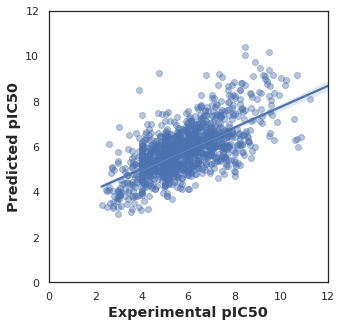

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show